<a href="https://colab.research.google.com/github/Richish/deep_learning_with_python/blob/master/ch631_advanced_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced RNN - Temperature prediction from timeseries data

takes 7 years of weather data taken at 10 minute interval.
Has 14 different readings like temp., air pressure, humidity etc.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2020-05-16 07:58:17--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  40.2MB/s    in 0.3s    

2020-05-16 07:58:18 (40.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


## loading the data

In [ ]:

data_file="jena_climate_2009_2016.csv"

df=pd.read_csv(data_file)

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [ ]:
# converting dataframe to 2d numpy array
float_data=df.to_numpy()
float_data.shape


(420551, 15)

In [ ]:
float_data[0]

array(['01.01.2009 00:10:00', 996.52, -8.02, 265.4, -8.9, 93.3, 3.33,
       3.11, 0.22, 1.94, 3.12, 1307.75, 1.03, 1.75, 152.3], dtype=object)

## plotting temperature timeseries

plotted


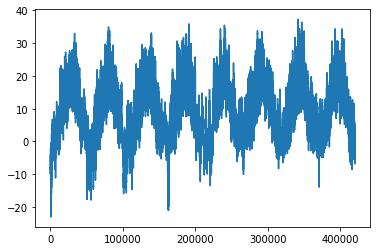

In [ ]:
temp=float_data[:,2]
time=float_data[:,0]
plt.plot(range(len(temp)), temp)
print("plotted")
plt.show()

### plotting temp data for first 10 days

plotted


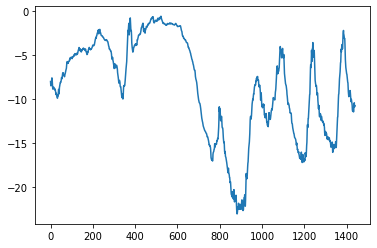

In [ ]:
plt.plot(range(1440), temp[:1440])
print("plotted")
plt.show()

## Preparing data

The exact formulation of the problem will be as follows: given data going as far back
as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps,
can you predict the temperature in delay timesteps? You’ll use the following parameter
values:
 lookback = 720—Observations will go back 5 days.
 steps = 6—Observations will be sampled at one data point per hour.
 delay = 144—Targets will be 24 hours in the future.
To get started, you need to do two things:
 Preprocess the data to a format a neural network can ingest. This is easy: the
data is already numerical, so you don’t need to do any vectorization. But each
timeseries in the data is on a different scale (for example, temperature is typically
between -20 and +30, but atmospheric pressure, measured in mbar, is
around 1,000). You’ll normalize each timeseries independently so that they all
take small values on a similar scale.
 Write a Python generator that takes the current array of float data and yields
batches of data from the recent past, along with a target temperature in the
future. Because the samples in the dataset are highly redundant (sample N and
sample N + 1 will have most of their timesteps in common), it would be wasteful
to explicitly allocate every sample. Instead, you’ll generate the samples on the
fly using the original data.
You’ll preprocess the data by subtracting the mean of each timeseries and dividing by
the standard deviation. You’re going to use the first 200,000 timesteps as training data,
so compute the mean and standard deviation only on this fraction of the data.

### Normalizing data by using mean and stddev.

In [ ]:
#mean = float_data[:200_000,1:].mean(axis=0)
#mean.shape, mean
#float_data[:,1:] -= mean
#std = float_data[:200000,1:].std(axis=0)
#mean, std
#float_data[:,1:] /= std
#float_data[:2]

In [ ]:
# remove datetime column
df=df.drop(columns='Date Time')
df.keys()

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [ ]:
mean=df.loc[:200_000].mean()
std=df.loc[:200_000].std()
df-=mean
df/=std
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.900147,-1.931360,-1.982112,-1.862801,1.072851,-1.307423,-1.473759,-0.798685,-1.476269,-1.478157,2.123752,-0.729505,-0.780679,-0.276138
1,0.906043,-1.975415,-2.025671,-1.915831,1.078829,-1.320428,-1.495198,-0.800751,-1.495026,-1.499323,2.172000,-0.931241,-0.887944,-0.463176
2,0.901326,-1.986711,-2.036840,-1.920017,1.108720,-1.323029,-1.497580,-0.802817,-1.498778,-1.501675,2.182355,-1.276144,-1.261227,-0.053308
3,0.898968,-1.964119,-2.013385,-1.886525,1.126655,-1.316527,-1.483288,-0.804883,-1.483772,-1.487564,2.157643,-1.178530,-1.317005,0.251495
4,0.898968,-1.959600,-2.010034,-1.882338,1.120677,-1.315226,-1.480906,-0.804883,-1.483772,-1.485212,2.153171,-1.191545,-1.261227,0.439688


In [ ]:
float_data=df.to_numpy()
float_data.shape

(420551, 14)

# New Section

### Datagenerator to yield a tuple (samples, targets)
where samples is one batch of input data and targets is the corresponding array of
target temperatures.

 Generator takes following parameters:
1. data—The original array of floating-point data, which you normalized in listing 6.32.
2. lookback—How many timesteps back the input data should go.
3. delay—How many timesteps in the future the target should be.
4. min_index and max_index—Indices in the data array that delimit which timesteps
to draw from. This is useful for keeping a segment of the data for validation
and another for testing.
5. shuffle—Whether to shuffle the samples or draw them in chronological order.
6. batch_size—The number of samples per batch.
7. step—The period, in timesteps, at which you sample data. You’ll set it to 6 in
order to draw one data point every hour.

In [ ]:
10//1.7

5.0

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """
    data: np.array > of full data set.
    lookback: no. of datapoints to look back in each sample.
    delay: no. of datapoints after current sample for which prediction is to be made, or which corresponds to y
    min_index: consider datapoints starting from this index only
    max_index: Take datapoint upto max this index only
    shuffle: shuffle the data before taking a batch out of data and yielding that
    batch_size: no. of samples to be yielded in a single batch
    step: not all data points will be considered, only datapoints at frequency- 'step' will be considered. 
            since data points aare at 10 min interval so step=6 implies only hourly data will be considered.
    return: a tuple of (samples, data_samples_at_delay). Samples is a 2d np array of shape: (batch_size, lookback, data.shape[-1]). Basically a a batch of samples, 
            where each sample contains a np array of shape(lookback, data.shape[-1])
            data_samples_at_delay is a 2d np array of shape: (batch_size, 1)- 1 since we only need temperature as output
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback # which rows that will contain the end of sample data, delay will be relative to this row.
    while True:
        if shuffle:
            # rows will be equal to batch_size
            rows=np.random.randint(i, max_index, size=batch_size) # basically row indexes.
        else: # not shuffled
            if i+batch_size>max_index: # if reached end, need to rotate and go to beginning to get new batch
                i=min_index+lookback
            rows=np.arange(i, min(i+batch_size,max_index))
            i+=len(rows) # move pointer to where end of next batch would be
        # initializing samples and targets to 0s.
        samples=np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets=np.zeros((len(rows),))
        # setting the value of samples and targets for each sample/target in a batch of batch_size
        for j, row in enumerate(rows):
            indeces=np.arange(row-lookback, row, step)
            samples[j]=data[indeces]
            targets[j]=data[row+delay][1] # we only need the temperature as output/label
        yield samples, targets

        
        
            
            
            
            
# generator(float_data, lookback=24*5*6, delay=24*6, min_index=0, max_index=200_000)

### Preparing the training, validation, and test generators

In [ ]:
lookback = 24*5*6 # 5 days data
step = 6
delay = 24*6 # 1 day's delay/prediction
batch_size = 128 # training batch size

In [ ]:
train_gen = generator(float_data,
                lookback=lookback,
                delay=delay,
                min_index=0,
                max_index=200_000,
                shuffle=True,
                step=step,
                batch_size=batch_size)

In [ ]:
val_gen = generator(float_data,
                lookback=lookback,
                delay=delay,
                min_index=200_001,
                max_index=300_000,
                shuffle=True,
                step=step,
                batch_size=batch_size)

In [ ]:
test_gen = generator(float_data,
                lookback=lookback,
                delay=delay,
                min_index=300_001,
                max_index=None,
                shuffle=True,
                step=step,
                batch_size=batch_size)

In [ ]:
val_steps = (300000 - 200001 - lookback) # how many val steps to look at whole data
test_steps = (len(float_data) - 300001 - lookback) # how many test steps to look at whole data

## A common-sense, non-machine-learning baseline

common sense says that  current temperature must be pretty close to last day's temperature
so making a common sense model for that to be used as baseline

In [ ]:
def evaluate_naive_method():
    batch_maes=[] # mae is mean absolute error= np.mean(np.abs(preds - targets))
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return (np.mean(batch_maes))
mae=evaluate_naive_method()
mae*std[1]

2.5718628310115936

This gives mae of 0.27315097027540164 which corresponds to 0.27*std[1]=2.26deg celcius.
Let's build a ml model to do better than this

## A basic machine-learning approach

Trying a simple densely connected model before trying a more computationally expensive RNN

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                53792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile and train
model.compile(optimizer='rmsprop', loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps/10)

Epoch 1/20
500/500 [==============================] - 32s 64ms/step - loss: 0.8622 - val_loss: 0.5318
Epoch 2/20
500/500 [==============================] - 32s 64ms/step - loss: 0.3769 - val_loss: 0.3161
Epoch 3/20
500/500 [==============================] - 32s 64ms/step - loss: 0.2934 - val_loss: 0.2815
Epoch 4/20
500/500 [==============================] - 32s 64ms/step - loss: 0.2717 - val_loss: 0.3675
Epoch 5/20
500/500 [==============================] - 32s 63ms/step - loss: 0.2631 - val_loss: 0.2803
Epoch 6/20
500/500 [==============================] - 31s 63ms/step - loss: 0.2552 - val_loss: 0.3143
Epoch 7/20
500/500 [==============================] - 32s 64ms/step - loss: 0.2497 - val_loss: 0.3029
Epoch 8/20
500/500 [==============================] - 32s 64ms/step - loss: 0.2444 - val_loss: 0.3137
Epoch 9/20
500/500 [==============================] - 32s 63ms/step - loss: 0.2406 - val_loss: 0.2939
Epoch 10/20
500/500 [==============================] - 31s 63ms/step - loss: 0.237

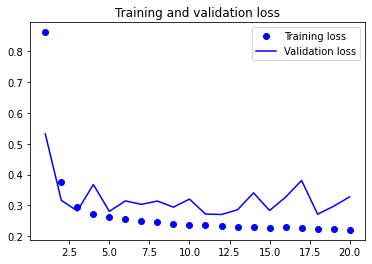

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

You may wonder, if a simple, well-performing model exists to go from the data to
the targets (the common-sense baseline), why doesn’t the model you’re training find it
and improve on it? Because this simple solution isn’t what your training setup is looking
for. The space of models in which you’re searching for a solution—that is, your
hypothesis space—is the space of all possible two-layer networks with the configuration
you defined. These networks are already fairly complicated. When you’re looking for a solution with a space of complicated models, the simple, well-performing baseline may
be unlearnable, even if it’s technically part of the hypothesis space. That is a pretty significant
limitation of machine learning in general: unless the learning algorithm is
hardcoded to look for a specific kind of simple model, parameter learning can sometimes
fail to find a simple solution to a simple problem.

## A first recurrent baseline

The previous approach first flattened the
timeseries, which removed the notion of time from the input data. Let’s instead look
at the data as what it is: a sequence, where causality and order matter. You’ll try a
recurrent-sequence processing model—it should be the perfect fit for such sequence
data, precisely because it exploits the temporal ordering of data points, unlike the first
approach.
Instead of the LSTM layer introduced in the previous section, you’ll use the GRU
layer, developed by Chung et al. in 2014.5 Gated recurrent unit (GRU) layers work
using the same principle as LSTM, but they’re somewhat streamlined and thus
cheaper to run (although they may not have as much representational power as
LSTM). This trade-off between computational expensiveness and representational
power is seen everywhere in machine learning.

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model=Sequential()
model.add(GRU(units=32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps/100)

Epoch 1/20
500/500 [==============================] - 134s 269ms/step - loss: 0.3035 - val_loss: 0.2509
Epoch 2/20
500/500 [==============================] - 135s 269ms/step - loss: 0.2844 - val_loss: 0.2527
Epoch 3/20
500/500 [==============================] - 135s 270ms/step - loss: 0.2806 - val_loss: 0.2439
Epoch 4/20
500/500 [==============================] - 134s 267ms/step - loss: 0.2745 - val_loss: 0.2788
Epoch 5/20
500/500 [==============================] - 134s 267ms/step - loss: 0.2714 - val_loss: 0.2430
Epoch 6/20
500/500 [==============================] - 132s 265ms/step - loss: 0.2656 - val_loss: 0.2788
Epoch 7/20
500/500 [==============================] - 131s 262ms/step - loss: 0.2616 - val_loss: 0.2582
Epoch 8/20
500/500 [==============================] - 132s 263ms/step - loss: 0.2579 - val_loss: 0.2790
Epoch 9/20
500/500 [==============================] - 132s 265ms/step - loss: 0.2524 - val_loss: 0.2659
Epoch 10/20
500/500 [==============================] - 132s 263m

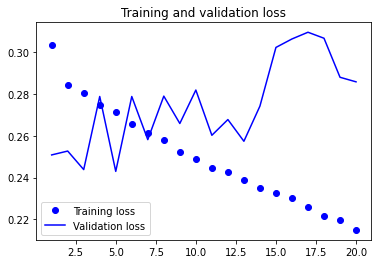

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Using Dropout in GRU

It has long been known that
applying dropout before a recurrent layer hinders learning rather than helping with
regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning,
6 determined the proper way to use dropout with a recurrent network: the same
dropout mask (the same pattern of dropped units) should be applied at every timestep,
instead of a dropout mask that varies randomly from timestep to timestep.
What’s more, in order to regularize the representations formed by the recurrent gates
of layers such as GRU and LSTM, a temporally constant dropout mask should be applied
to the inner recurrent activations of the layer (a recurrent dropout mask). Using the
same dropout mask at every timestep allows the network to properly propagate its
learning error through time; a temporally random dropout mask would disrupt this
error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly
into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related
arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let’s add
dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting.
Because networks being regularized with dropout always take longer to fully converge,
you’ll train the network for twice as many epochs.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps/100)

Epoch 1/40
500/500 [==============================] - 141s 282ms/step - loss: 15685896.8233 - val_loss: 0.8212
Epoch 2/40
500/500 [==============================] - 141s 282ms/step - loss: 127627.4596 - val_loss: 0.7981
Epoch 3/40
500/500 [==============================] - 141s 281ms/step - loss: 11611.5594 - val_loss: 0.7757
Epoch 4/40
500/500 [==============================] - 141s 282ms/step - loss: 19799.4998 - val_loss: 0.8602
Epoch 5/40
500/500 [==============================] - 141s 282ms/step - loss: 2419.1571 - val_loss: 0.4852
Epoch 6/40
500/500 [==============================] - 141s 281ms/step - loss: 139.4870 - val_loss: 0.2864
Epoch 7/40
500/500 [==============================] - 142s 284ms/step - loss: 2883.0217 - val_loss: 0.2736
Epoch 8/40
500/500 [==============================] - 141s 283ms/step - loss: 92.8131 - val_loss: 0.3057
Epoch 9/40
460/500 [==========================>...] - ETA: 9s - loss: 2214.5062

KeyboardInterrupt: ignored

You’re no longer overfitting during the first 30
epochs. But although you have more stable evaluation scores, your best scores aren’t
much lower than they were previously.

## stacking RNN layers

Recall the description of
the universal machine-learning workflow: it’s generally a good idea to increase the
capacity of your network until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As
long as you aren’t overfitting too badly, you’re likely under capacity.
Increasing network capacity is typically done by increasing the number of units in
the layers or adding more layers. Recurrent layer stacking is a classic way to build
more-powerful recurrent networks: for instance, what currently powers the Google
Translate algorithm is a stack of seven large LSTM layers—that’s huge.
To stack recurrent layers on top of each other in Keras, all intermediate layers
should return their full sequence of outputs (a 3D tensor) rather than their output at
the last timestep. This is done by specifying return_sequences=True.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps/100)

Epoch 1/40
500/500 [==============================] - 286s 571ms/step - loss: 7930715.9974 - val_loss: 0.7765
Epoch 2/40
500/500 [==============================] - 285s 570ms/step - loss: 45297.7779 - val_loss: 0.7654
Epoch 3/40
500/500 [==============================] - 283s 567ms/step - loss: 4129.7790 - val_loss: 0.6865
Epoch 4/40
500/500 [==============================] - 283s 567ms/step - loss: 1722.6837 - val_loss: 0.6580
Epoch 5/40
500/500 [==============================] - 284s 567ms/step - loss: 51920.0268 - val_loss: 0.6321
Epoch 6/40
500/500 [==============================] - 284s 568ms/step - loss: 52098.8892 - val_loss: 0.6772
Epoch 7/40
500/500 [==============================] - 286s 571ms/step - loss: 90296.5013 - val_loss: 0.5796
Epoch 8/40
500/500 [==============================] - 285s 569ms/step - loss: 17022.8038 - val_loss: 0.5471
Epoch 9/40
500/500 [==============================] - 286s 571ms/step - loss: 48864.6832 - val_loss: 0.5539
Epoch 10/40
500/500 [=======

KeyboardInterrupt: ignored

You can see that the added layer does improve the
results a bit, though not significantly. You can draw two conclusions:
 Because you’re still not overfitting too badly, you could safely increase the size of
your layers in a quest for validation-loss improvement. This has a non-negligible
computational cost, though.
 Adding a layer didn’t help by a significant factor, so you may be seeing diminishing
returns from increasing network capacity at this point.

## Using bidirectional RNNs

Remarkably, the fact that the RNN layers in this section have processed sequences in
chronological order (older timesteps first) may have been an arbitrary decision. At least,
it’s a decision we made no attempt to question so far. Could the RNNs have performed
well enough if they processed input sequences in antichronological order, for instance
(newer timesteps first)? Let’s try this in practice and see what happens. All you need to
do is write a variant of the data generator where the input sequences are reverted along
the time dimension (replace the last line with yield samples[:, ::-1, :], targets).
Training the same one-GRU-layer network that you used in the first experiment in this
section, you get the results shown in figure 6.24.

The reversed-order GRU strongly underperforms even the common-sense baseline,
indicating that in this case, chronological processing is important to the success of your
approach. This makes perfect sense: the underlying GRU layer will typically be better at
remembering the recent past than the distant past, and naturally the more recent
weather data points are more predictive than older data points for the problem (that’s
what makes the common-sense baseline fairly strong). Thus the chronological version
of the layer is bound to outperform the reversed-order version. Importantly, this isn’t
true for many other problems, including natural language: intuitively, the importance
of a word in understanding a sentence isn’t usually dependent on its position in the sentence.
Let’s try the same trick on the LSTM IMDB

### imdb training on words in sentences in reverse order

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)



Using TensorFlow backend.


17465344/17464789 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.4818 - acc: 0.7678 - val_loss: 0.3257 - val_acc: 0.8748
Epoch 2/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.3073 - acc: 0.8827 - val_loss: 0.3058 - val_acc: 0.8860
Epoch 3/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.2577 - acc: 0.9057 - val_loss: 0.3260 - val_acc: 0.8708
Epoch 4/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.2231 - acc: 0.9185 - val_loss: 0.3825 - val_acc: 0.8448
Epoch 5/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.1908 - acc: 0.9355 - val_loss: 0.6360 - val_acc: 0.8010
Epoch 6/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.1744 - acc: 0.9386 - val_loss: 0.3437 - val_acc: 0.8800
Epoch 7/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.1549 - acc: 0.9453 - val_loss: 0.3542 - val_acc:

Importantly, an
RNN trained on reversed sequences will learn different representations than one
trained on the original sequences, much as you would have different mental models if
time flowed backward in the real world—if you lived a life where you died on your first
day and were born on your last day. In machine learning, representations that are different
yet useful are always worth exploiting, and the more they differ, the better: they
offer a new angle from which to look at your data, capturing aspects of the data that
were missed by other approaches, and thus they can help boost performance on a
task. This is the intuition behind ensembling, a concept we’ll explore in chapter 7.
A bidirectional RNN exploits this idea to improve on the performance of chronologicalorder
RNNs. It looks at its input sequence both ways (see figure 6.25), obtaining potentially
richer representations and capturing patterns that may have been missed by the
chronological-order version alone.

To instantiate a bidirectional RNN in Keras, you use the Bidirectional layer, which takes
as its first argument a recurrent layer instance. Bidirectional creates a second, separate
instance of this recurrent layer and uses one instance for processing the input sequences
in chronological order and the other instance for processing the input sequences in
reversed order. Let’s try it on the IMDB sentiment-analysis task.

### Training and evaluating a bidirectional LSTM fro imdb

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 123s 6ms/step - loss: 0.5651 - acc: 0.7132 - val_loss: 0.7149 - val_acc: 0.7346
Epoch 2/10
20000/20000 [==============================] - 123s 6ms/step - loss: 0.3634 - acc: 0.8565 - val_loss: 0.5857 - val_acc: 0.7938
Epoch 3/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.2774 - acc: 0.8956 - val_loss: 0.2970 - val_acc: 0.8858
Epoch 4/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.2388 - acc: 0.9151 - val_loss: 0.3859 - val_acc: 0.8686
Epoch 5/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.2128 - acc: 0.9268 - val_loss: 0.3062 - val_acc: 0.8814
Epoch 6/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.1862 - acc: 0.9354 - val_loss: 0.3152 - val_acc: 0.8870
Epoch 7/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.1708 - acc: 0.9398 - val_loss: 0.5289 - v

### Training bidirectional GRU for Weather forecast

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps/100)

Epoch 1/40
500/500 [==============================] - 111s 221ms/step - loss: 0.2928 - val_loss: 0.2541
Epoch 2/40
500/500 [==============================] - 109s 218ms/step - loss: 0.2741 - val_loss: 0.2548
Epoch 3/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2674 - val_loss: 0.2635
Epoch 4/40
500/500 [==============================] - 108s 217ms/step - loss: 0.2621 - val_loss: 0.2788
Epoch 5/40
500/500 [==============================] - 108s 217ms/step - loss: 0.2574 - val_loss: 0.2632
Epoch 6/40
500/500 [==============================] - 108s 216ms/step - loss: 0.2526 - val_loss: 0.3095
Epoch 7/40
500/500 [==============================] - 108s 215ms/step - loss: 0.2451 - val_loss: 0.2853
Epoch 8/40
500/500 [==============================] - 108s 216ms/step - loss: 0.2385 - val_loss: 0.3109
Epoch 9/40
500/500 [==============================] - 108s 215ms/step - loss: 0.2325 - val_loss: 0.2657
Epoch 10/40
500/500 [==============================] - 108s 216m

KeyboardInterrupt: ignored

# Summary:

 As you first learned in chapter 4, when approaching a new problem, it’s good to
first establish common-sense baselines for your metric of choice. If you don’t
have a baseline to beat, you can’t tell whether you’re making real progress.
 Try simple models before expensive ones, to justify the additional expense.
Sometimes a simple model will turn out to be your best option.
 When you have data where temporal ordering matters, recurrent networks are
a great fit and easily outperform models that first flatten the temporal data.
 To use dropout with recurrent networks, you should use a time-constant dropout
mask and recurrent dropout mask. These are built into Keras recurrent layers,
so all you have to do is use the dropout and recurrent_dropout arguments
of recurrent layers.
 Stacked RNNs provide more representational power than a single RNN layer.
They’re also much more expensive and thus not always worth it. Although they
offer clear gains on complex problems (such as machine translation), they may
not always be relevant to smaller, simpler problems.
 Bidirectional RNNs, which look at a sequence both ways, are useful on naturallanguage
processing problems. But they aren’t strong performers on sequence
data where the recent past is much more informative than the beginning of the
sequence.

# 